In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy
import librosa
import scipy.fftpack as fft
from scipy.signal import get_window
from IPython.display import Audio
import matplotlib.pyplot as plt

%matplotlib inline


In [192]:
from utils import *

# Complete MFCC Front End
Preemphasis algorithm taken from lecture slides  
Code for reference: https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial  
Used librosa.features.delta for temporal derivatives

In [193]:
path = r"audio_files\pitch_gender1.wav"
y, sr = librosa.load(path, sr=44100)
Audio(path, rate=sr)

In [194]:
start_time = 1.967
end_time = 2.181
cropped = y[int(start_time*sr):int(end_time*sr)]
Audio(data=cropped,rate=sr)

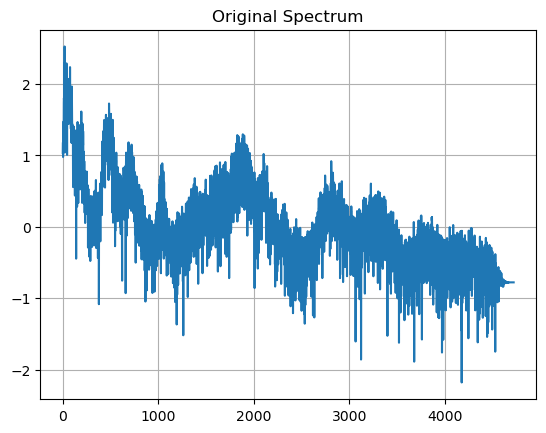

In [177]:
plt.title("Original Spectrum")
plt.plot(np.log10(np.abs(fft.fft(cropped,axis=0)[:len(cropped)//2])))
plt.grid(True)

In [178]:
# Preemphasis
preemphasized = preemphasis(signal=cropped)
Audio(data=preemphasized, rate=sr)

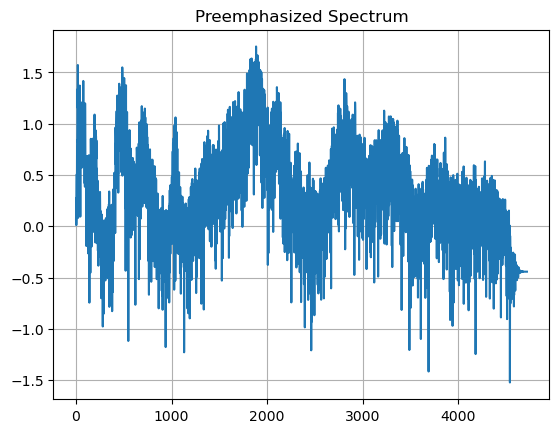

In [179]:
plt.title("Preemphasized Spectrum")
plt.plot(np.log10(np.abs(fft.fft(preemphasized,axis=0)[:len(preemphasized)//2])))
plt.grid(True)

By applying a high-pass filter through pre-emphasis, the frequencies around 2000-3000 are amplified while the lower frequencies are slightly attenuated.

In [182]:
# Frame audio
frames = frame_audio(preemphasized)
print(frames.shape)

(22, 1024)


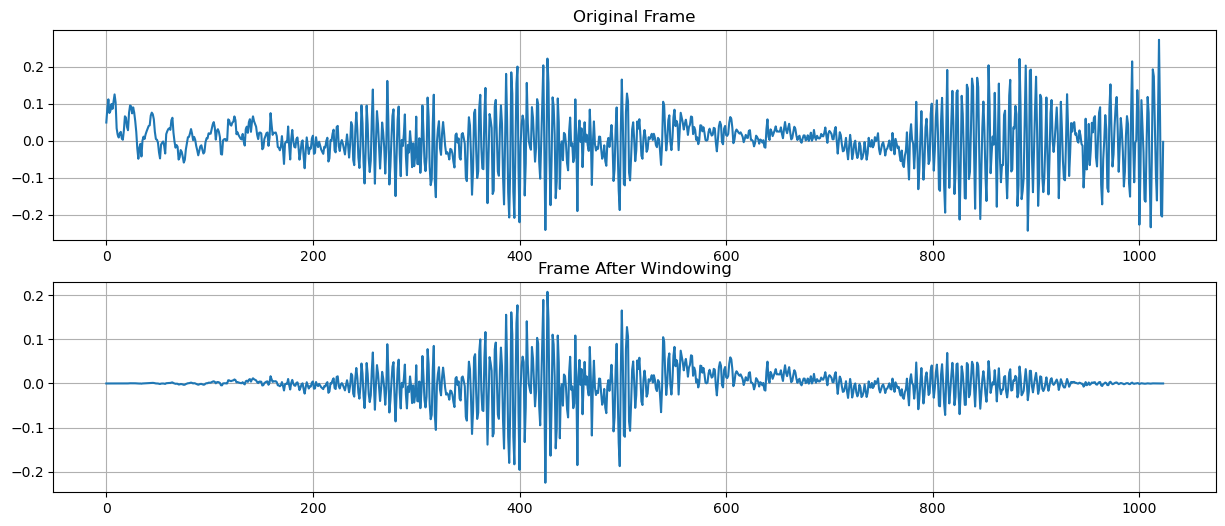

In [183]:
# Window frames
windowed = window_frames(frames)
ind = 12
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(frames[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(windowed[ind])
plt.title('Frame After Windowing')
plt.grid(True)

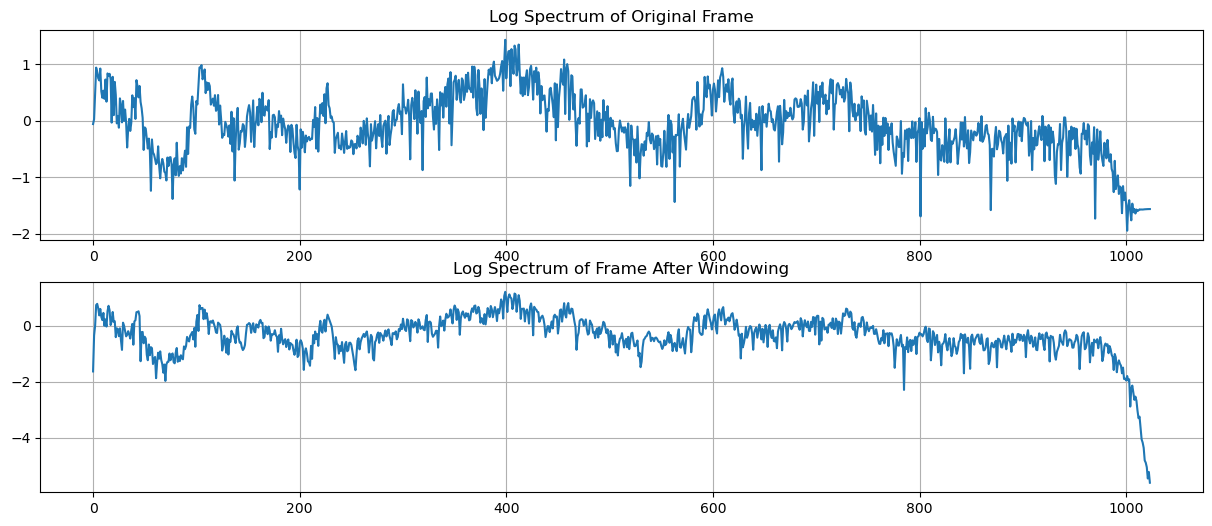

In [114]:
ind = 12
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(np.log10(np.abs(fft.fft(frames[ind],axis=0)))[:len(frames[ind])//2])
plt.title('Log Spectrum of Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(np.log10(np.abs(fft.fft(windowed[ind],axis=0)))[:len(windowed[ind])//2])
plt.title('Log Spectrum of Frame After Windowing')
plt.grid(True)

The audio is separated into different frames based on the hop size, which is set at a default of 10 ms. The length of each frame is based on the desired FFT size, which is set to 1024 samples, or 23 ms. Framing the audio produces a spectrum that is similar to the original since the clipped audio only exhibits one vowel, but there is unwanted spectral noise due to the high frequency artifacts that come from the rectangular window. After using a Hamming window, the spectral noise is smoothed.

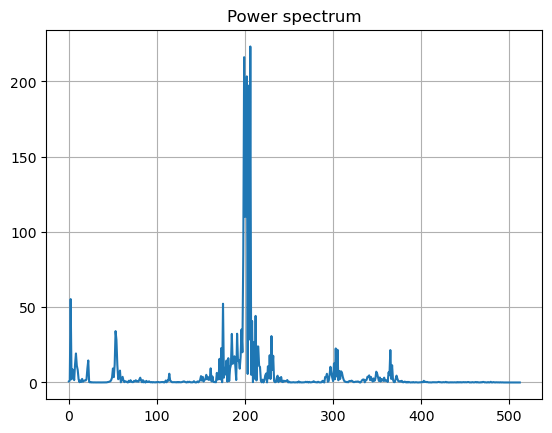

In [184]:
audio_power = fft_frames(frames)
plt.plot(audio_power[ind])
plt.title('Power spectrum')
plt.grid(True)

Calculating the power spectrum makes clear where the peaks by squaring the magnitude of the spectrum.

In [185]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 40
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, sample_rate=44100)
filter_points
print(filter_points)
print(mel_freqs)

MEL min: 0.0
MEL max: 3923.337321740179
[  0   1   3   4   6   8  10  13  15  18  21  25  28  32  37  41  47  52
  58  65  72  80  89  98 108 119 131 144 159 174 191 209 229 251 275 301
 329 360 393 429 469 512]
[    0.            62.03206123   129.56123192   203.07465067
   283.102625     370.22245675   465.0626067    568.30722807
   680.70110182   803.05500937   936.25158133  1081.25166459
  1239.10125362  1410.93903604  1598.00460681  1801.64741034
  2023.3364751   2264.67101077  2527.39194458  2813.39447989
  3124.74176774  3463.67978992  3832.65356087  4234.32476547
  4671.59095972  5147.60647302  5665.8051627   6229.92518502
  6844.03596129  7512.56753367  8240.34252238  9032.61091489
  9895.08793802 10833.99528616 11856.10600303 12968.79334071
 14180.08394848 15498.71577503 16934.20110187 18496.89516255
 20198.07084273 22050.        ]


The indices and corresponding frequencies of the endpoints of our triangular mel filters are calculated. Using np.linspace, we can then calculate the up and down slopes of the each triangular filter.

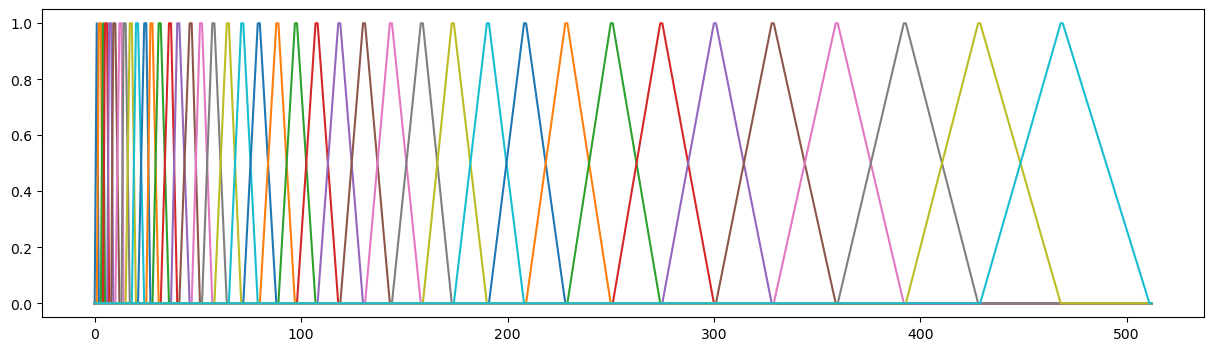

In [186]:
filters = get_filters(filter_points)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

We need to normalize each filter based on its width so we don't amplify unwanted high frequencies.

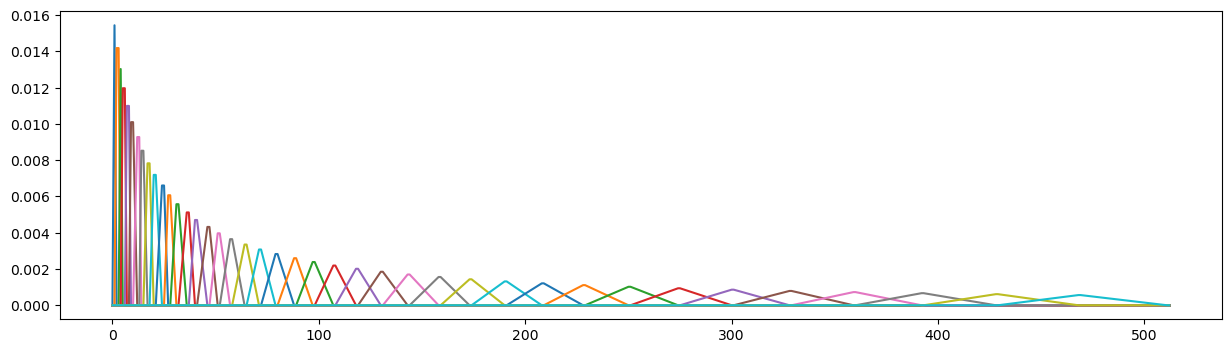

In [187]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])


By using matrix multiplication, for each filter, we can weight the frequency components and bin them together. We then compute the base 10 logarithm of the spectrum.

(40, 22)


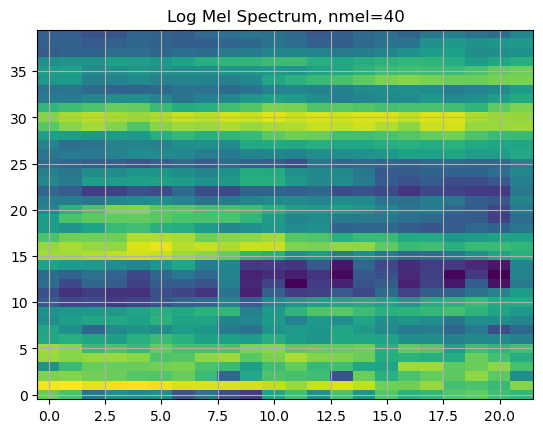

In [188]:
audio_filtered = filters@audio_power.T
audio_log = 10*np.log10(audio_filtered+1e-9)
print(audio_log.shape)
plt.imshow(audio_log, aspect='auto', origin='lower')
plt.title(f'Log Mel Spectrum, nmel={mel_filter_num}')
plt.grid(True)

The Mel-scale filterbank weights frequency components around each mel-scale center frequency using triangular filters and bins them together, which is similar to human hearing. I chose nmel=40, which means there are 40 bins.

In [189]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

mfcc_13 = dct_filters @ audio_log
print(mfcc_13.shape)

(13, 22)


Text(0.5, 1.0, 'MFCCs (nmfcc=13)')

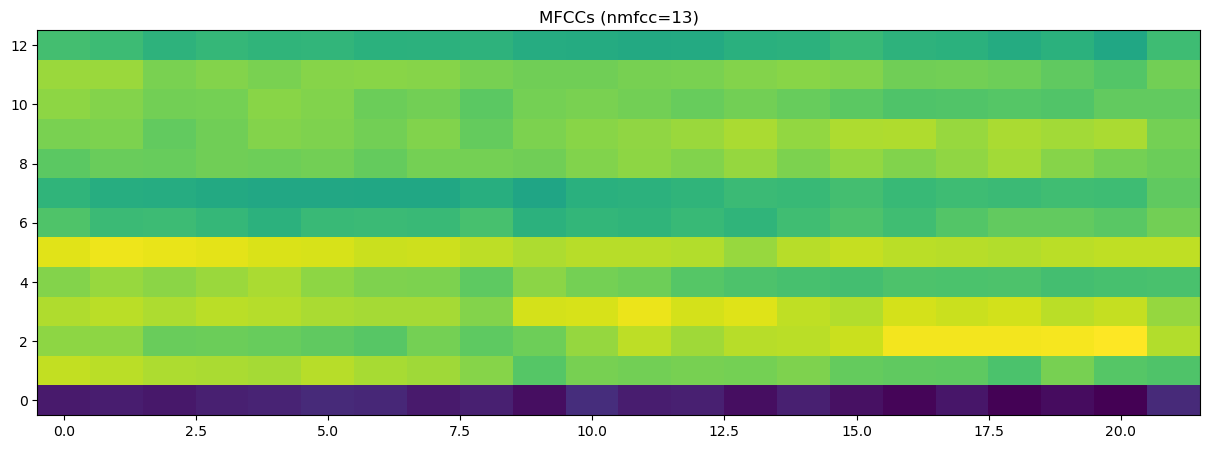

In [190]:
plt.figure(figsize=(15,5))
plt.imshow(mfcc_13, aspect='auto', origin='lower')
plt.title(f'MFCCs (nmfcc={dct_filter_num})')

The DCT computes coefficients that describe how the log mel spectrum can be decomposed into weighted cosines, in a sense capturing the frequency components of the log mel spectrum. The first couple coefficients capture the overall shape of the spectrum.

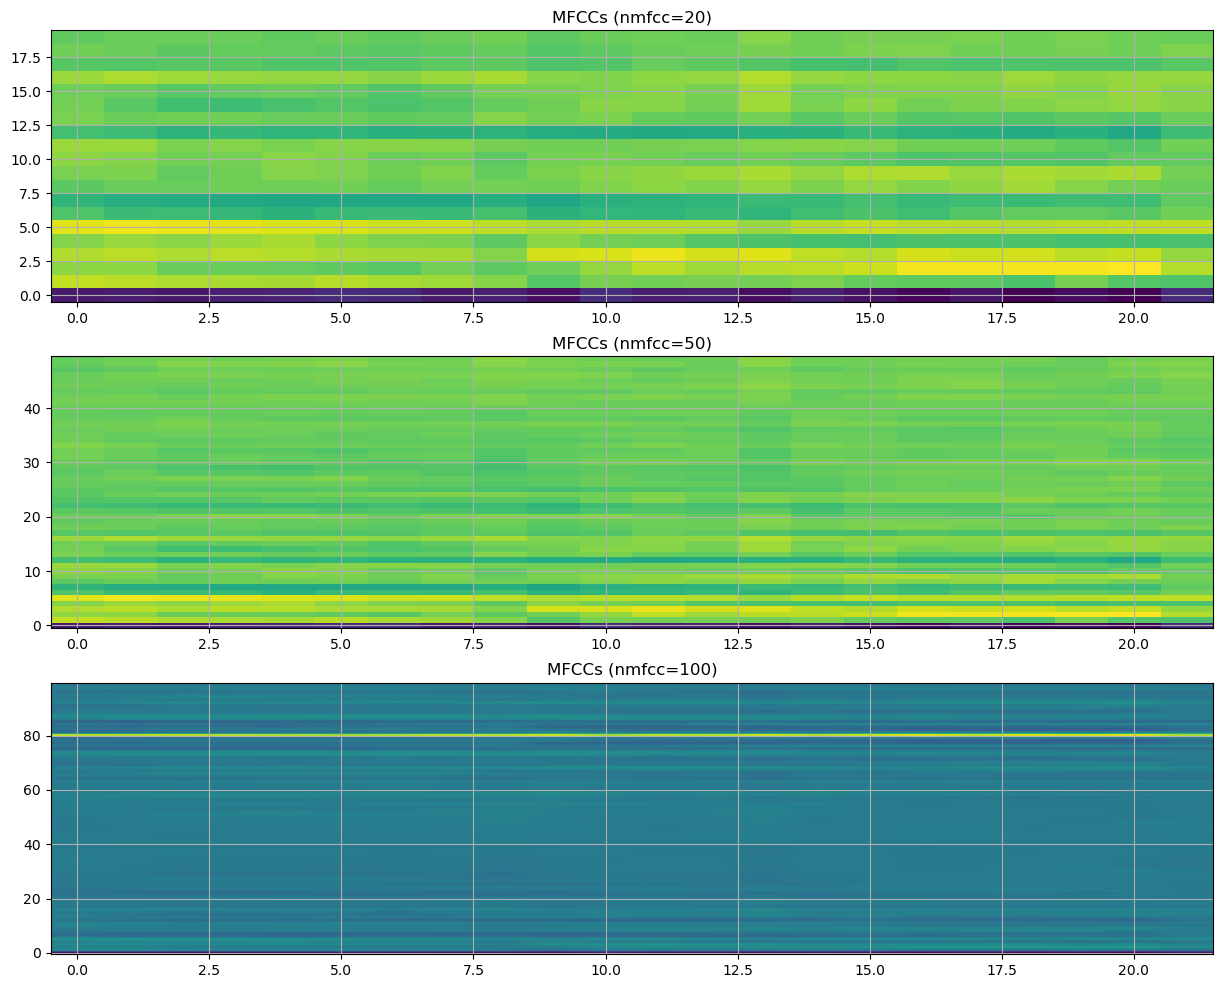

In [191]:
dct_filter_num = 20
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_20 = dct_filters @ audio_log

dct_filter_num = 50
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_50 = dct_filters @ audio_log

dct_filter_num = 100
dct_filters = dct(dct_filter_num, mel_filter_num)
mfcc_100 = dct_filters @ audio_log

plt.figure(figsize=(15,12))
plt.subplot(3, 1, 1)
plt.imshow(mfcc_20, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=20)')
plt.grid(True)
plt.subplot(3, 1, 2)
plt.imshow(mfcc_50, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=50)')
plt.grid(True)
plt.subplot(3, 1, 3)
plt.imshow(mfcc_100, aspect='auto', origin='lower')
plt.title('MFCCs (nmfcc=100)')
plt.grid(True)

In [174]:
print(np.argmax(mfcc_100[:,0]))

80


The cepstral coefficients describe how the log mel spectrum can be decomposed into weighted cosines that capture the different frequency components of the spectrum. By increasing the number of cepstral coefficients, more information from the log mel spectrum is retained. While the first couple MFCCs are the most important since they capture the overall shape of the spectrum, it seems that increasing the number of MFCCs up to 100 captures a peak at the 80th MFCC, which indicates presence of timbre, texture, and/or spectral noise.

# Complete LPCC Front End
Preemphasis and frame blocking code same as MFCC front end  
Used librosa.lpc to convert windowed frames into LPC  (Burg's Method for LPC parameter estimation by autocorrelation)  
Conversion from LPC to LPCC taken from: https://www.mathworks.com/help/dsp/ref/lpctofromcepstralcoefficients.html  
Parameter weighting taken from slides  
Used librosa.features.delta for temporal derivatives

In [195]:
path = r"audio_files\pitch_gender1.wav"
y, sr = librosa.load(path, sr=44100)
Audio(path, rate=sr)

In [196]:
start_time = 1.967
end_time = 2.181
cropped = y[int(start_time*sr):int(end_time*sr)]
Audio(data=cropped,rate=sr)

In [223]:
from utils import *
lpc, error = compute_lpc(cropped)
print(lpc.shape)
print(error)

(13, 22)
[1.03703    1.08376069 1.02375753 0.84313323 0.90244144 1.33249497
 1.28052333 1.32557625 0.86937711 2.05631937 1.024461   0.77594074
 1.21301812 2.40605167 1.22607619 1.00322609 1.16034341 1.94459294
 1.25852173 1.04377954 1.00360702 0.80213438]


(13, 22)


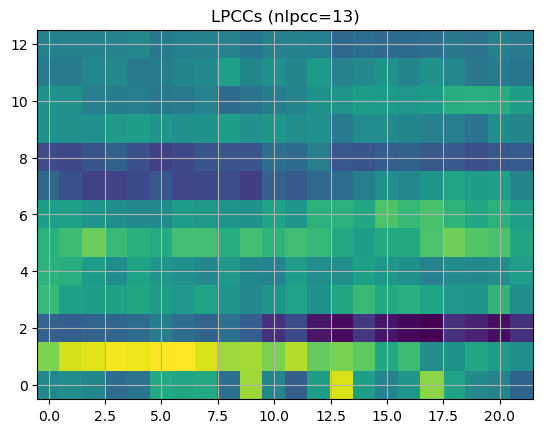

In [224]:
lpcc = compute_lpcc(lpc, error)
print(lpcc.shape)
plt.imshow(lpcc, aspect='auto', origin='lower')
plt.title('LPCCs (nlpcc=13)')
plt.grid(True)

(13, 22)


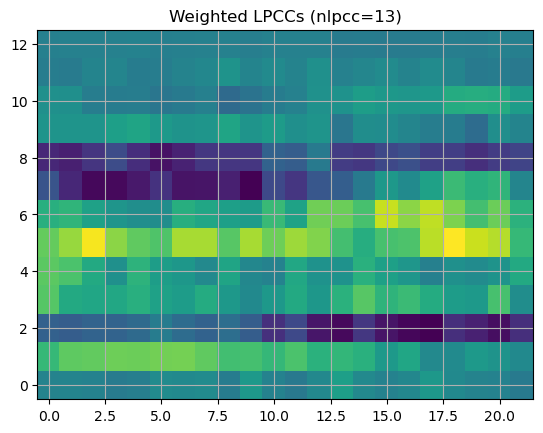

In [225]:
lpcc_weighted = []
for i in range(lpcc.shape[1]):
    lpcc_weighted.append(parameter_weighting(lpcc[:,i]))
lpcc_weighted = np.vstack(lpcc_weighted).T
print(lpcc_weighted.shape)
plt.imshow(lpcc_weighted, aspect='auto', origin='lower')
plt.title('Weighted LPCCs (nlpcc=13)')
plt.grid(True)